# Notebook for loading MAR netcdfs

In [61]:
import xarray as xr
import os
import fsspec
import gcsfs

Setup the file names

In [62]:
fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab', cache_timeout = 0, token='../secrets/ldeo-glaciology-bc97b12df06b.json')
gcsdir = 'gs://ldeo-glaciology'
marsdir = 'MAR'
filepattern = 'MARv3.12-20km-daily-ERA5*'
pattern = os.path.join(gcsdir, marsdir, filepattern)
NCs = fs.glob(pattern)
print(f"Total of {len(NCs)} MAR files.\n")
NCs

Total of 21 MAR files.



['ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2000.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2001.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2002.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2003.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2004.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2005.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2006.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2007.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2008.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2009.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2010.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2011.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2012.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2013.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2014.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2015.nc',
 'ldeo-glaciology/MAR/MARv3.12-20km-daily-ERA5-2016.nc',
 'ldeo-glaciology/MAR/MARv3.12-

Try loading one netcdf

In [63]:
NCs_urls = ['gs://' + x + '#mode=bytes' for x in NCs]
openfile = fs.open(NCs_urls[0], mode='rb') 
ds1 = xr.open_dataset(openfile)

this one netcdf should be one year of data, so check the length of the TIME dimension.  2000 was a leap year so this should be 366 :+1:

In [64]:
len(ds1.TIME)  

366

Now load all the files

In [65]:
NCs_urls = ['https://storage.googleapis.com/' + x + '#mode=bytes' for x in NCs] # needed for open_mfdataset
ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', 
                       concat_dim='TIME',
                      )

Check that the concatanation along the TIME dimension has worked ok. 

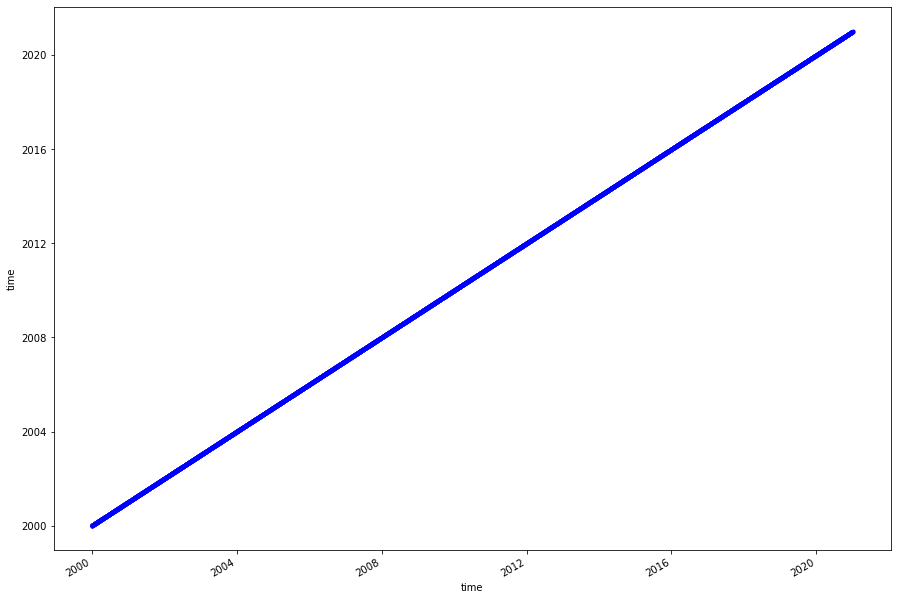

In [68]:
ds.TIME.plot.line("b.",size=10)

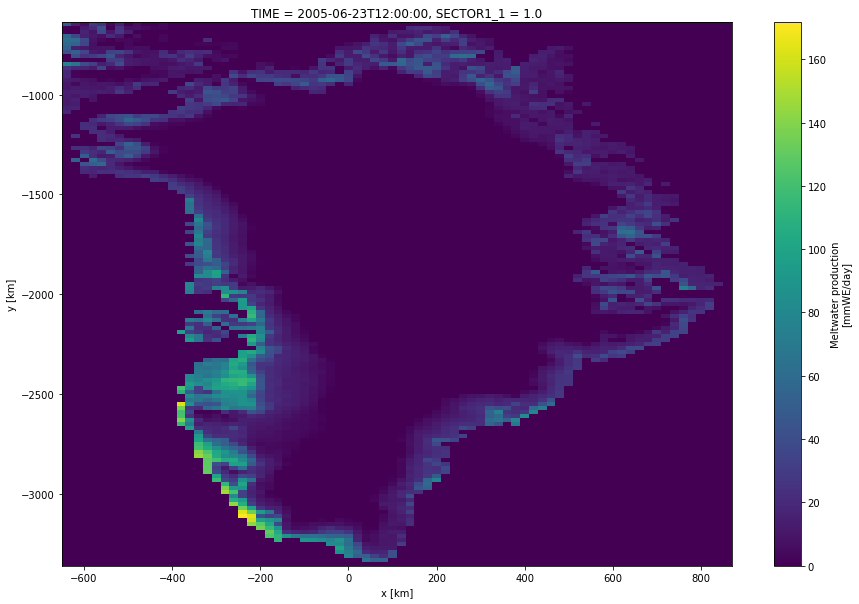

In [72]:
ds.ME[2000].plot(size=10)